In [1]:
%matplotlib inline
import datacube
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas as gpd
from odc.geo.geom import Geometry
from deafrica_tools.plotting import display_map
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.plotting import xr_animation, rgb


In [2]:
import os

os.environ['AWS_S3_ENDPOINT'] = 's3.af-south-1.amazonaws.com'
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
os.environ['AWS_DEFAULT_REGION'] = 'af-south-1'
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

print("AWS endpoint:", os.getenv('AWS_S3_ENDPOINT'))

AWS endpoint: s3.af-south-1.amazonaws.com


In [3]:
from deafrica_tools.plotting import display_map

# Coordinates of Lake Manyara
lat = -25.43
lon = 29.33

# Buffer for the region around the lake
lat_buffer = 0.04
lon_buffer = 0.1

# Define the range
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Bounding box in [min_lon, min_lat, max_lon, max_lat]
bbox = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]
print("Bounding box:", bbox)

# Display the map with the bounding box
display_map(x=lon_range, y=lat_range)


Bounding box: [29.229999999999997, -25.47, 29.43, -25.39]


In [4]:
from pystac_client import Client
import datetime

# Define STAC API URL
url = 'https://explorer.digitalearth.africa/stac'

# Open the STAC catalog
catalog = Client.open(url)


# Define time range (adjust as needed)
start_date = "2024-06-01"
end_date = "2024-12-01"

# Set the product/collection name
collections = ['cgls_lwq100_2024_nrt']  # Landsat 8 Surface Reflectance

# Search the STAC catalog
query = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime=f"{start_date}/{end_date}"
)

# Fetch matching items
items = list(query.items())

# Display number of matched scenes
print(f"Found {len(items)} items for 'cgls_lwq100_2016_2024' over Lake Manyara.")

# Show the first item (optional)
items[0] if items else "No items found"

Found 10 items for 'cgls_lwq100_2016_2024' over Lake Manyara.


<Item id=6b465a85-64de-5151-aa85-85fa16027bec>

In [5]:
print(items[0].assets.keys())


dict_keys(['num_obs', 'last_obs', 'tsm_mean', 'Rw443_rep', 'Rw490_rep', 'Rw560_rep', 'Rw665_rep', 'Rw705_rep', 'Rw740_rep', 'Rw783_rep', 'Rw842_rep', 'Rw865_rep', 'Rw945_rep', 'chla_mean', 'first_obs', 'Rw1375_rep', 'Rw1610_rep', 'Rw2190_rep', 'RwDayNum_rep', 'quality_flags', 'turbidity_mean', 'trophic_state_index', 'floating_cyanobacteria'])


In [5]:
from odc.stac import stac_load

# Coordinate Reference System (WGS 84)
crs = "EPSG:4326"

# Measurements you want to load from 'ls8_sr'
bands=('chla_mean','tsm_mean', 'turbidity_mean', 'trophic_state_index', 'floating_cyanobacteria')

# Load data with all parameters included
ds = stac_load(
    items=items,
    crs=crs,
    bands=bands,
    bbox=bbox,
    min_gooddata=0.50,
    groupby="solar_day",                # ensures same-day images grouped together
    dask_chunks={}  # adjust chunk size as needed
)

ds

<xarray.Dataset> Size: 4MB
Dimensions:                 (latitude: 90, longitude: 224, time: 10)
Coordinates:
  * latitude                (latitude) float64 720B -25.39 -25.39 ... -25.47
  * longitude               (longitude) float64 2kB 29.23 29.23 ... 29.43 29.43
    spatial_ref             int32 4B 4326
  * time                    (time) datetime64[ns] 80B 2024-09-01 ... 2024-12-01
Data variables:
    chla_mean               (time, latitude, longitude) float32 806kB nan ......
    tsm_mean                (time, latitude, longitude) float32 806kB nan ......
    turbidity_mean          (time, latitude, longitude) float32 806kB nan ......
    trophic_state_index     (time, latitude, longitude) float32 806kB nan ......
    floating_cyanobacteria  (time, latitude, longitude) float32 806kB nan ......

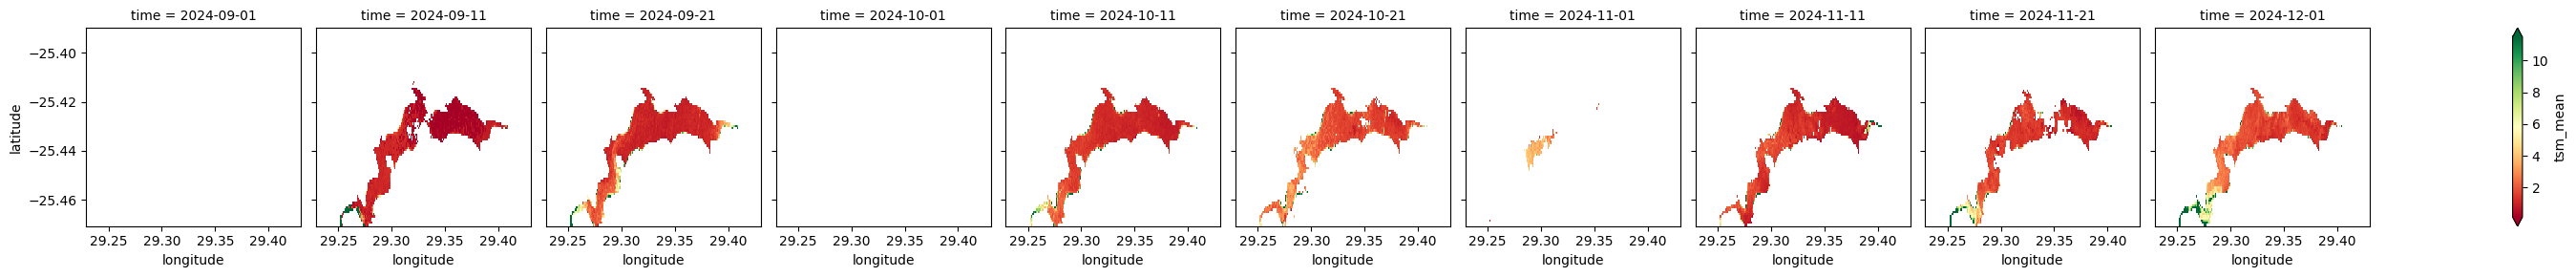

In [9]:
ds = ds.where(ds <= 996921)
ds['tsm_mean'].plot(col='time', cmap='RdYlGn', robust=True)


In [ ]:
from IPython.display import Image

xr_animation(ds=ds,
             bands=('chla_mean'),
             output_path='animated_timeseries.mp4',
             interval=1000,imshow_kwargs={'cmap': 'RdYlGn', 'vmin': 0, 'vmax': 20},
             width_pixels=800,colorbar_kwargs= { "colors":"red", "labelsize": 14}  )

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def display_animation_in_notebook(
    ds,
    band,
    width_pixels=600,
    interval=400,
    cmap="viridis",
    show_date=True,
    add_colorbar=True,
):
    """
    Display an animation inline in a Jupyter Notebook for a single-band time-series xarray.Dataset.
    Shows original values (no normalization). Adds band name as title.
    """
    if band not in ds.data_vars:
        raise ValueError(f"Band '{band}' not found in dataset. Choose from {list(ds.data_vars)}.")

    array = ds[band].values  # shape: [time, lat, lon]
    time = ds.time.values

    # Compute value range for the colorbar (no normalization)
    vmin = np.nanmin(array)
    vmax = np.nanmax(array)

    # Get shape
    t, h, w = array.shape
    scale = width_pixels / w
    fig, ax = plt.subplots()
    fig.set_size_inches(width_pixels / 72, h * scale / 72)

    im = ax.imshow(array[0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f"{band}", fontsize=14, color="black", pad=10)

    cb = None
    if add_colorbar:
        cb = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05)
        cb.ax.tick_params(labelsize=10, color='black')
        cb.outline.set_edgecolor('black')

    text_obj = None
    if show_date:
        text_obj = ax.text(
            0.99, 0.01, str(time[0]), color="white", fontsize=14,
            ha="right", va="bottom", transform=ax.transAxes,
            bbox=dict(facecolor="black", alpha=0.5, pad=2)
        )

    ax.axis("off")

    def update(i):
        im.set_array(array[i])
        if text_obj:
            text_obj.set_text(str(time[i]))

    anim = FuncAnimation(fig, update, frames=t, interval=interval)
    plt.close(fig)

    return HTML(anim.to_jshtml())
display_animation_in_notebook(
    ds=ds,
    band="tsm_mean",
    width_pixels=800,
    interval=500,
    cmap='RdYlGn'
)


In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from skimage.exposure import rescale_intensity
from IPython.display import HTML

def display_animation_in_notebook(
    ds,
    band,
    width_pixels=600,
    interval=400,
    cmap="viridis",
    show_date=True,
    percentile_stretch=(0.02, 0.98),
    add_colorbar=True,
):
    """
    Display an animation inline in a Jupyter Notebook for a single-band time-series xarray.Dataset.
    """
    if band not in ds.data_vars:
        raise ValueError(f"Band '{band}' not found in dataset. Choose from {list(ds.data_vars)}.")

    array = ds[band].values  # shape: [time, lat, lon]
    time = ds.time.values

    # Handle NaNs and stretch contrast
    vmin, vmax = np.nanpercentile(array, [percentile_stretch[0]*100, percentile_stretch[1]*100])
    array = rescale_intensity(np.nan_to_num(array), in_range=(vmin, vmax), out_range=(0.0, 1.0))

    t, h, w = array.shape
    scale = width_pixels / w
    fig, ax = plt.subplots()
    fig.set_size_inches(width_pixels / 72, h * scale / 72)
    im = ax.imshow(array[0], cmap=cmap, vmin=0, vmax=1)
    cb = None

    if add_colorbar:
        cb = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05)
        cb.ax.tick_params(labelsize=10, color='black')
        cb.outline.set_edgecolor('black')

    text_obj = None
    if show_date:
        text_obj = ax.text(
            0.99, 0.01, str(time[0]), color="white", fontsize=14,
            ha="right", va="bottom", transform=ax.transAxes,
            bbox=dict(facecolor="black", alpha=0.5, pad=2)
        )

    ax.axis("off")

    def update(i):
        im.set_array(array[i])
        if text_obj:
            text_obj.set_text(str(time[i]))

    anim = FuncAnimation(fig, update, frames=t, interval=interval)

    plt.close(fig)  # Prevents duplicate static plot display

    return HTML(anim.to_jshtml())
display_animation_in_notebook(
    ds=ds,
    band="tsm_mean",
    width_pixels=800,
    interval=1000,
    cmap="magma"
)
